In [1]:
# N_simulation
from __future__ import division
import numpy as np
# from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy import interpolate 
import matplotlib.pyplot as plt
import pandas as pd # to read excel
import datetime
from datetime import date
import datetime
from myfunctions_multi_scale import *
%matplotlib inline

In [2]:
# importing parameters for validation with Reading data 

xval = pd.ExcelFile('../data/input.xlsx')
dfval = xval.parse('Parameters_Reading',header=None)

# assigmment of parameters to values: 
for key,val in zip(dfval.iloc[:][0],dfval.iloc[:][1]):
    exec(key + '=val')
    print(key,val)

n_reactors = np.int(n_reactors)

umol_to_percent_DW 0.0014
n_days 14.0
Next0 110.0
Nint0 1.05
m0 0.19724999999999998
S 35.0
Nintcrit 2.0
n_reactors 1.0
Qp 459.5833333333333
Qsea 224910.0
Nsea 110.0
dilution 0.0
miu 0.027
Nintmax 4.2
Nintmin 0.7
KN 1.2
Ks 14.0
Vmax 60.0
Z 1.0
KI 20.0
K0 1.5
Ka 0.15
Topt 18.0
Tmin 5.0
Tmax 31.5
n 2.0
losses20 0.0016
teta 1.047
Sopt 18.0
Smin 0.0
Smax 45.0
Shigh 30.0
Slow 12.0


In [12]:
# import all data for model valodation (source: HOBO data from aerated cage in Reading - Alex Ch, 2017)

period1i = datetime.datetime(2017, 4, 20)
hour1i = 24 * (int(period1i.strftime("%j"))-1) + 8

period2i = datetime.datetime(2017, 5, 3)
hour2i = 24 * (int(period2i.strftime("%j"))-1) + 14

period3i = datetime.datetime(2017, 5, 17)
hour3i = 24 * (int(period3i.strftime("%j"))-1) + 14

period4i = datetime.datetime(2017, 6, 15)
hour4i = 24 * (int(period4i.strftime("%j"))-1) + 12

period5i = datetime.datetime(2017, 6, 28)
hour5i = 24 * (int(period5i.strftime("%j"))-1) + 11

x2 = pd.ExcelFile('../data/HOBO.xlsx')

dfV1 = x2.parse('period1_PAR',header=None)
dfV4 = x2.parse('period2_PAR',header=None)
dfV5 = x2.parse('period3_PAR',header=None)

#IV1 and TV1 based only on IMS and not on HOBO data

IV2, TV2,IV2_average,TV2_average = [],[],[],[]
for vali,valT in zip(dfV1.iloc[3:2488:1][5],dfV1.iloc[3:2488:1][3]):
    IV2.append(vali)
    TV2.append(float(valT))
for i in range(1,len(IV2),4):
    IV2_average.append(np.mean(IV2[i-1:i+3:1]))
    TV2_average.append(np.mean(TV2[i-1:i+3:1]))

IV3, TV3,IV3_average,TV3_average = [],[],[],[]
for vali,valT in zip(dfV1.iloc[3+14*24*4:2488:1][5],dfV1.iloc[3+14*24*4:2488:1][3]):
    IV3.append(vali)
    TV3.append(float(valT))
for i in range(1,len(IV3),4):
    IV3_average.append(np.mean(IV3[i-1:i+3:1]))
    TV3_average.append(np.mean(TV3[i-1:i+3:1]))
    
IV4, TV4,IV4_average,TV4_average = [],[],[],[]
for vali,valT in zip(dfV4.iloc[13:1249:1][5],dfV4.iloc[13:1249:1][3]):
    IV4.append(vali)
    TV4.append(float(valT))
for i in range(1,len(IV4),4):
    IV4_average.append(np.mean(IV4[i-1:i+3:1]))
    TV4_average.append(np.mean(TV4[i-1:i+3:1]))

IV5, TV5,IV5_average,TV5_average = [],[],[],[]
for vali,valT in zip(dfV5.iloc[7:1345:1][5],dfV5.iloc[7:1345:1][3]):
    IV5.append(vali)
    TV5.append(float(valT))
for i in range(1,len(IV5),4):
    IV5_average.append(np.mean(IV5[i-1:i+3:1]))
    TV5_average.append(np.mean(TV5[i-1:i+3:1]))

In [13]:
# Import of IMS I and T data
#ref: Chemodanov, A., Robin, A., Jinjikhashvily, G., Yitzhak, D., Liberzon, A., Israel, A., & Golberg, A. (2019).
# Feasibility study of Ulva sp.(Chlorophyta) intensive cultivation in a coastal area of the Eastern Mediterranean Sea.
# Biofuels, Bioproducts and Biorefining, 13(4), 864-877.
dFI = pd.read_csv('../data/ims_data_2017_umol_photons.csv',encoding= 'unicode_escape',header=None)
dfT = pd.read_csv('../data/ims_T_data_2017.csv',encoding= 'unicode_escape',header=None)

In [14]:
days = list(range(1,366))
I_plot = np.zeros(24*365)
light_hours = list(range(5,19))
for day in days:
    for hour in light_hours:
        I_plot[(day - 1)*24 + hour] = float(dFI.iloc[day][hour-1])

annual_hours = list(range(1,(366-1)*24+1))
f0_plot = interpolate.interp1d(annual_hours, I_plot,kind = 'linear')

In [15]:
# process IMS I and T Data

# I data
days = list(range(1,366))
I = np.zeros(24*365)
Temp = np.zeros(24*365-1-24)
light_hours = list(range(5,19))
for day in days:
    for hour in light_hours:
        I[(day - 1)*24 + hour] = 0.43 * float(dFI.iloc[day][hour-1])

# T data
annual_hours_short = list(range(2,2741*3-1))
annual_hours = list(range(1,(366-1)*24+1))
f0_plot = interpolate.interp1d(annual_hours, I_plot,kind = 'linear')
f0 = interpolate.interp1d(annual_hours, I,kind = 'linear')

TV1 = []
for valT in zip(dfT.iloc[1:2741:1][4]):
    TV1.append(float(valT[0]))
TV1[-1]

TV_hours_reduced = annual_hours_short[0:-1:3]
f2 = interpolate.interp1d(TV_hours_reduced,TV1,kind = 'linear')
TV_interp = f2(annual_hours_short[0:-5:1])

In [16]:
# Lists of initial and boundary conditions and empiric results for returns 1-5:

t0_all = [hour1i, hour2i, hour3i, hour4i, hour5i]
tf_all = [hour1i + int(13*24), hour2i + int(14*24), hour3i + int(12*24-4), hour4i + int(13*24-4), hour5i + int(14*24-2)]
Nsea_all = [90, 111, 91, 148, 206] # in period 3 used final concentrations
mi_all = [1.315*0.15, 1.315*0.15, 1.315*0.15, 1.306*0.15, 1.306*0.15]
mf_real = [4590, 2781, 1120, 2001, 1069]
Nint0_all = [2, 1.05, 0.65, 3, 1.06]# Nint0 of first period - assumed 2 (after 1 week starvation), and of forth assumed 3 (after fertilizing in Porter)
Nintf_all = [1.05, 0.65, 0.98, 1.06, 1.40]
functions = [Reading_val, Reading_val_IMS]
TV_average = [TV1, TV2_average, TV3_average, TV4_average, TV5_average]
IV_average = [1, IV2_average, IV3_average, IV4_average, IV5_average]
xlabels_all = [['20 April', '27 April', '3 May'],['3 May', '10 May', '17 May'],['17 May', '23 May', '29 May'],['15 June', '22 june', '28 June'],['28 June', '5 July', '12 July']]

In [ ]:
miu = 0.027
losses20 = 0.0016
Nintmax = 4.2
Nintcrit = 2
Ks = 14
Vmax = 60
KI = 144.8
K0 = 1.5
Ka = 0.01
Smin = 0
Sopt = 18
Smax = 45
Topt = 25
Tmax = 35
n = 2
Tmin = 5

Starting point
for period 2 and using irradiance data type 0
The modeled m is: 39.94[kg FW/cage], The measured m is 4.96[kg FW/cage]
The calculated error is: -7.052

Starting point
for period 2 and using irradiance data type 1
The modeled m is: 12.88[kg FW/cage], The measured m is 4.96[kg FW/cage]
The calculated error is: -1.597

Starting point
for period 4 and using irradiance data type 0
The modeled m is: 43.98[kg FW/cage], The measured m is 3.57[kg FW/cage]
The calculated error is: -11.319

Starting point
for period 4 and using irradiance data type 1
The modeled m is: 9.99[kg FW/cage], The measured m is 3.57[kg FW/cage]
The calculated error is: -1.798

Starting point
for period 5 and using irradiance data type 0
The modeled m is: 17.07[kg FW/cage], The measured m is 1.91[kg FW/cage]
The calculated error is: -7.937

Starting point
for period 5 and using irradiance data type 1
The modeled m is: 6.66[kg FW/cage], The measured m is 1.91[kg FW/cage]
The calculated error is: -2.487



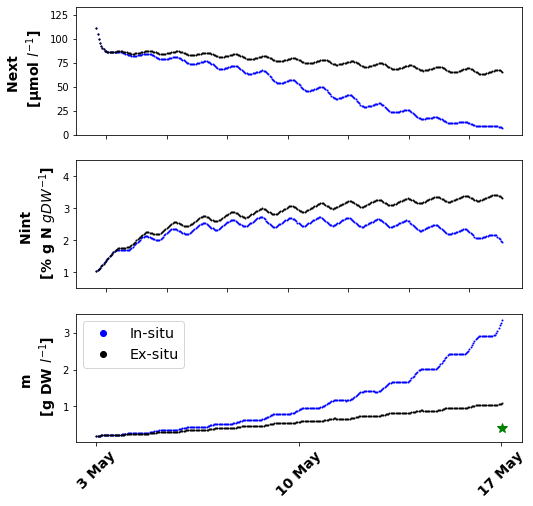

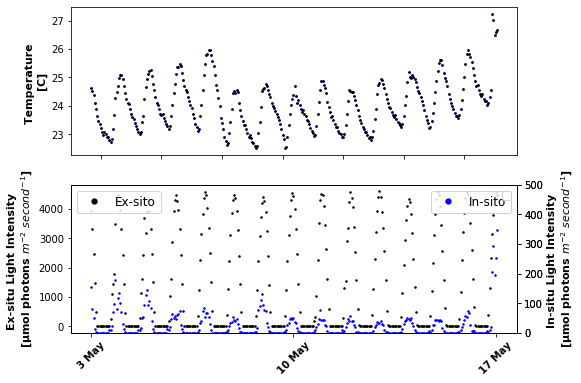

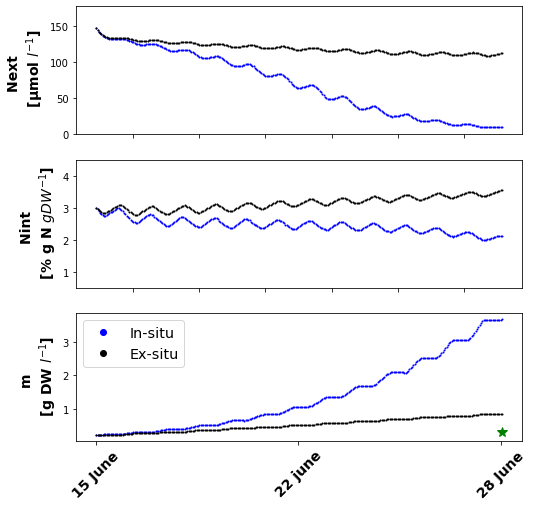

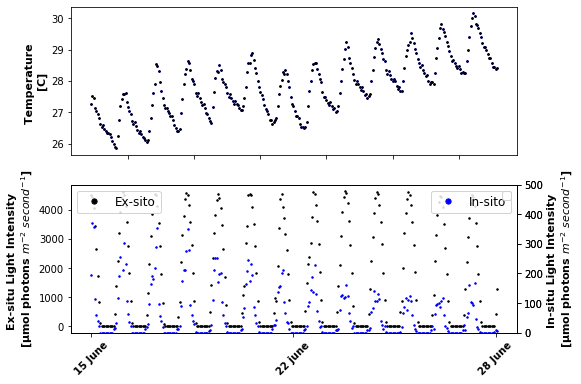

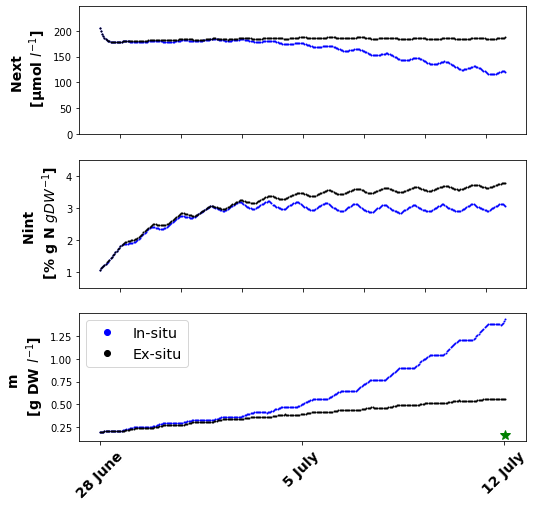

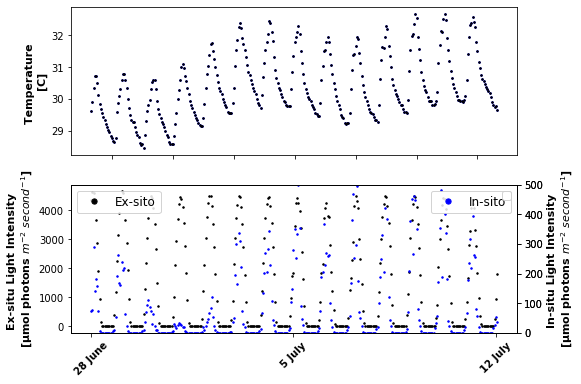

In [17]:
# Data validation figures - models based on: 0- HOBO irradiance data; 1- IMS irradiance data 

# Parameter lists:

Errors = []
returns = [2, 4, 5]
colors = ['blue', 'black']
colors2 = ['blue', 'black']
labels = ['In-situ','Ex-situ']

# model simulation
for k in returns:
    fig, ax = plt.subplots(3,1,figsize=(8,8))
    fig, ax2 = plt.subplots(2,1,figsize=(8,6))
    
    t0 = t0_all[k-1]
    t = list(range(t0,tf_all[k-1]))
    Nsea = Nsea_all[k-1]
    Next0 = Nsea_all[k-1]
    Nint0 = Nint0_all[k-1]
    m0 = mi_all[k-1]
    TV_reduced = TV_average[k-1][1:len(t)+1]
    f1 = interpolate.interp1d(t, TV_reduced,kind = 'linear')
    xlabels = xlabels_all[k-1]    
    FINAL_M = []
    
    for j in range(2):
        function = functions[j]
        if j == 0:
            IV_reduced = IV_average[k-1][1:len(t)+1]
            f0 = interpolate.interp1d(t, IV_reduced,kind = 'linear')
        elif j == 1:
            f0 = interpolate.interp1d(annual_hours, I,kind = 'linear')
        
        NSEA, NEXT, NINT, M, Total_N, T, Total_biomass = [],[],[],[],[],[],[]
        print('Starting point')
        
        # setup initial conditions identical for all reactors
        x0 = n_reactors*[Nsea, Next0, Nint0, m0]
        args = (Nintcrit,Nintmax,Nintmin,Vmax,Ks,KN,miu,S,Z,KI,K0,Ka,Topt,Tmin,Tmax,losses20,
                teta,Sopt,Smin,Smax, Qp, Qsea, Nsea,f1,f0,dilution,n,umol_to_percent_DW)

        # solve the ODEs using the new syntax
        sol = solve_ivp(function, [t[0], t[-1]], x0, args=args, t_eval = t)

        # take the solution of the state variables:
        M_farm, N_farm = [], []
        NSEA.append(sol.y[0,:])
        NEXT.append(sol.y[1,:])
        NINT.append(sol.y[2,:])
        M.append(sol.y[3,:])
        M_farm.append((M[-1][-1] - m0) * 1.785)
        N_farm.append((M[-1][-1] * NINT[-1][-1] * 1.785 / 100))
        Total_biomass.append(round(sum(M_farm),3))
        Total_N.append(round(sum(N_farm),4))


        T.append(sol.t)
        t = T[0]

        ax[0].plot(t,NEXT[-1],'.',color=colors[j], markersize=2)
        ax[0].set_ylim([0,Nsea*1.2])
        ax[1].plot(t,NINT[-1],'.',color=colors[j], markersize=2)
        ax[1].set_ylim([0.5,4.5])
        ax[2].plot(t,M[-1],'.',color=colors[j], markersize=2)
        ax[2].set_xticks(t[0:len(t):int(len(t)/2-1)])
        ax[0].set_xticklabels([])
        ax[1].set_xticklabels([])
        ax[2].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=14, weight="bold")
        ax[2].legend(labels, fontsize = 'x-large',markerscale = 6)


        ax[0].set_ylabel('Next \n [µmol $l^{-1}$]',fontsize=14, weight="bold")
        ax[1].set_ylabel('Nint \n [% g N $g DW^{-1}$]',fontsize=14, weight="bold")
        ax[2].set_ylabel('m \n [g DW $l^{-1}$]',fontsize=14, weight="bold")

        # plot I and T
        ax3 = ax2[1].twinx()
        ax3.set_ylim([0,500])
        ax2[0].plot(t,TV_reduced,'.',color=colors2[j], markersize=3)
        if j == 0:
            ax3.plot(t,IV_reduced,'.',color=colors2[j], markersize=3)
            
        elif j == 1:
            ax2[1].plot(t,f0_plot(t),'.',color=colors2[j], markersize=3)      
        
        ax2[0].set_ylabel('Temperature \n[C]',fontsize=11, weight="bold")
        ax2[1].set_ylabel('Ex-situ Light Intensity \n[µmol photons $m^{-2}$ $second^{-1}$]',fontsize=11, weight="bold")
        if j == 0:
            ax3.set_ylabel('In-situ Light Intensity \n[µmol photons $m^{-2}$ $second^{-1}$]',fontsize=11, weight="bold")
        
        ax2[0].set_xticklabels([])
        ax2[1].set_xticklabels([])
        ax2[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
        ax2[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")
        ax2[1].legend(['Ex-sito'],loc='upper left',fontsize = 'large',markerscale = 3.5,framealpha=0.85)
        ax3.legend(['In-sito'],loc='upper right',fontsize = 'large',markerscale = 3.5,framealpha=0.85)
        
        final_m = round(M [-1][-1] * 1.785 / 0.15,2)
        measured_m = round(mf_real[k-1] * 1.785 / 1000,2)
        error = round((measured_m - final_m) / measured_m,3)
        Errors.append(error)
        
        print('for period ' + str(k) + ' and using irradiance data type ' + str(j))
        print('The modeled m is: ' + str(final_m) + '[kg FW/cage], The measured m is ' + str(measured_m) + '[kg FW/cage]')
        print('The calculated error is: ' + str(error) + '\n')
    ax[2].plot(t[-1],0.15*mf_real[k-1]/1000,'*',color='green',markersize = 10)
    ...
    ...


Light Intensity data types: IMS 

Starting point
for period 1, using Light Intensity data type 1
The modeled m is: 11.76[kg FW/cage], The measured m is 8.19[kg FW/cage]
The calculated error is: -0.436



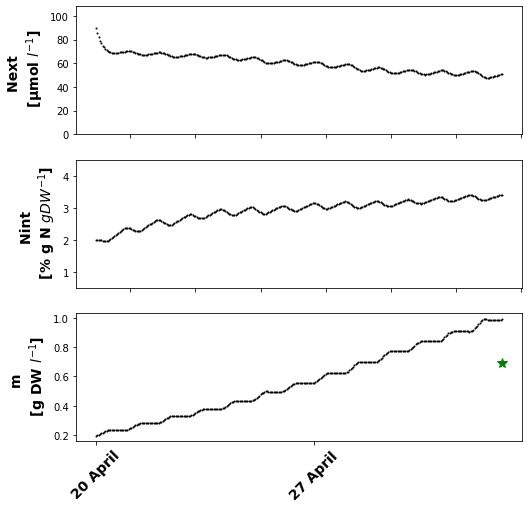

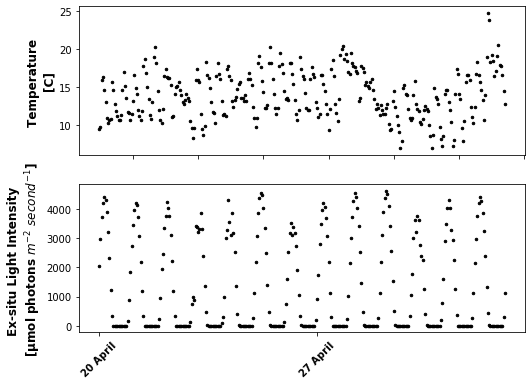

In [18]:
# Data validation based on period 1 (only IMS data)  

# Parameter lists:

fig, ax = plt.subplots(3,1,figsize=(8,8))
    
t0 = t0_all[0]
t = list(range(t0,tf_all[0]))
Nsea = Nsea_all[0]
Next0 = Nsea_all[0]
Nint0 = Nint0_all[0]
m0 = mi_all[0]
TV_reduced = TV_average[0][1:len(t)+1]
f1 = interpolate.interp1d(t, TV_reduced,kind = 'linear')
f2 = interpolate.interp1d(t, TV_reduced,kind = 'linear')
xlabels = xlabels_all[0]    
FINAL_M = []


# model simulation

print('Light Intensity data types: IMS \n')

NSEA, NEXT, NINT, M, Total_N, T, Total_biomass = [],[],[],[],[],[],[]
print('Starting point')

# setup initial conditions identical for all reactors
x0 = n_reactors*[Nsea, Next0, Nint0, m0]
dilution = 0

args = (Nintcrit,Nintmax,Nintmin,Vmax,Ks,KN,miu,S,Z,KI,K0,Ka,Topt,Tmin,Tmax,losses20,
        teta,Sopt,Smin,Smax, Qp, Qsea, Nsea,f2,f0,dilution,n,umol_to_percent_DW)

# solve the ODEs using the new syntax
sol = solve_ivp(Reading_val_IMS, [t[0], t[-1]], x0, args=args, t_eval = t)

# take the solution of the state variables:
M_farm = []
N_farm = []
NSEA.append(sol.y[0,:])
NEXT.append(sol.y[1,:])
NINT.append(sol.y[2,:])
M.append(sol.y[3,:])
M_farm.append((M[-1][-1] - m0) * 1.785)
N_farm.append((M[-1][-1] * NINT[-1][-1] * 1.785 / 100))
Total_biomass.append(round(sum(M_farm),1))
Total_N.append(round(sum(N_farm),2))


T.append(sol.t)
t = T[0]

ax[0].plot(t,NEXT[-1],'.',color='black', markersize=2)
ax[0].set_ylim([0,Nsea*1.2])
ax[1].plot(t,NINT[-1],'.',color='black', markersize=2)
ax[1].set_ylim([0.5,4.5])
ax[2].plot(t,M[-1],'.',color='black', markersize=2)
ax[2].plot(t[-1],0.15*mf_real[1-1]/1000,'*',color='green',markersize = 10)
ax[2].set_xticks(t[0:24*7*2:24*7-1])
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
ax[2].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=14, weight="bold")

ax[0].set_ylabel('Next \n [µmol $l^{-1}$]',fontsize=14, weight="bold")
ax[1].set_ylabel('Nint \n [% g N $g DW^{-1}$]',fontsize=14, weight="bold")
ax[2].set_ylabel('m \n [g DW $l^{-1}$]',fontsize=14, weight="bold")

# plot I and T

fig, ax2 = plt.subplots(2,1,figsize=(8,6))
ax2[0].plot(t,TV_reduced,'.',color='black', markersize=5)
ax2[1].plot(t,f0_plot(t),'.',color='black', markersize=5)

ax2[0].set_ylabel('Temperature \n[C]',fontsize=12, weight="bold")
ax2[1].set_ylabel('Ex-situ Light Intensity \n[µmol photons $m^{-2}$ $second^{-1}$]',fontsize=12, weight="bold")
ax2[0].set_xticklabels([])
ax2[1].set_xticklabels([])
ax2[1].set_xticks(t[0:24*7*2:24*7-1])
ax2[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")


final_m = round(M [-1][-1] * 1.785 / 0.15,2)
measured_m = round(mf_real[0] * 1.785 / 1000,2)
error = round((measured_m - final_m) / measured_m,3)

print('for period 1, using Light Intensity data type ' + str(j))
print('The modeled m is: ' + str(final_m) + '[kg FW/cage], The measured m is ' + str(measured_m) + '[kg FW/cage]')
print('The calculated error is: ' + str(error) + '\n')